# Tutorial #1: Selecting From the Library of Presimulated Components

**Target Audience:** Front-end User

**Table of Contents:**
1. [Selecting a the template of the component.](#component)
2. [Meaning / notation of characteristics associated with component.](#reading-characteristics)
3. [**[Main Functionality!]** Finding geometrical parameters which best suits target characteristics.](#select-characteristics)
4. [Using best geometry in `Qiskit Metal`](#qiskit-metal)


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!pip install ../.

# Section 1: Selecting a Component <a id="component"></a>

First, let's see which components are currently supported.

In [ ]:
import metal_library as mlib

print(mlib.supported_components)

Now we can place one of the supported components into `Reader`. This is a class meant to parse the library (located at `C:\\...\metal_library\library`)

In [ ]:
reader = mlib.Reader(component_name='TransmonCross')
print(reader)

Interfacing with the library will be conducted through this object.

# Section 2: Understanding Structure of Characteristics <a id="reading-characteristics"></a>

Since we're conducting science, we must use exact language when talking about the characteristics we're pulling.

Example of **imprecise** language:
- 👎 "Get the coupling strength?"

Example of **precise** language:
- 👍 "Get the coupling strength between the readout cavity and qubit"
- 👍 "Get the coupling strength between qubit #1 and the bus (connecting qubit #1 and qubit #2)"

The following attributes / functions were created to help the front-end user follow precisely what each component characteristic means.



### Component Types
In simulations, we don't always simulate the entire chip at once. So there's a property `component_types` to view which combinations we've simulated.

In [ ]:
reader.component_types

### Characteristics of Component Type

Within each `component_type`, the types of observables / component characteristics you can extract change. Obviously if you have simulated only a qubit you can't extract cavity resonant frequency. To see which characteristics are supported, we can use `Reader.get_characteristic_info`.

Note: `component_type` must be an entry in `Reader.component_types`

In [ ]:
reader.get_characteristic_info(component_type="QubitOnly")

In [ ]:
reader.get_characteristic_info(component_type="QubitCavity")

In [ ]:
reader.get_characteristic_info(component_type="QubitDriveline");

# Section 3: (MAIN FUNCTIONALITY) Finding a Geometry for Given Characteristics <a id="select-characteristics"></a>

Now that we understand which `component_name` and `component_type` gives us the parameters we desire. We can begin to select geometries which will yield promising results.

First, you must select a `component_type` and prepare the library for the selection class (`Selector`).

In [ ]:
reader = mlib.Reader(component_name='TransmonCross')
reader.read_library(component_type='QubitOnly')

Note: if you failed to run the previous cell, you haven't selected a `component_type`, and `Selector` will throw an error like:
```
reader = mlib.Reader(component_name='TransmonCross')
selector = mlib.Selector(reader)

>> AttributeError: '`Reader` must have `Reader.library` created. Run `Reader.read_library` before initalizing `Selector`.'

```

Now that everything is loaded, we can initalize the `Selector` class.

In [ ]:
#### REMINDER: don't skip the previous cell! 
selector = mlib.Selector(reader)
print(selector)

### Let's select a geometry which results in the closest qubit characteristics.

Call `Selector.find_closest`

Documentation:

```
Main functionality. Select the closest geometry for a set of characteristics.

Args:
    target_params (dict): A dictionary where the keys are the column names in `self.characteristic`,
                          and the values are the target values to compare against.
    num_top (int): The number of rows with the smallest Euclidean distances to return.
    metric (str, optional): Metric to determine closeness. Defaults to "Euclidian". 
                            Must choose from `self.__supported_metrics__`.
    display (boo, optional): Print out results? Defaults to True.

Returns:
    indexes_smallest (pd.Index): Indexes of the 'num_top' rows with the smallest distances to the target parameters.
    best_characteristics (list[dict]): Associated characteristics. Ranked closest to furthest, same order as `best_geometries`
    best_geometries (list[dict]): Geometries in the style of QComponent.options. Ranked closest to furthest.
```


In [ ]:
# You can find the supported metrics here...
selector.__supported_metrics__

In [ ]:
indexes, chars, best_geoms = selector.find_closest(target_params={"Qubit_Frequency_GHz": 4,
                                                                  "Qubit_Anharmonicity_MHz": 200},
                                                   num_top=3,
                                                   metric="Euclidean",
                                                   display=True)

You can do a weighted Euclidean metric instead.

\begin{equation*}
    F(\{P_i\},\{p_i\}) = \sum_i w_i\frac{(P_i - p_i)^2}{P_i}
\end{equation*}

Here $w_i$ are weights which default to 1 if not user-defined.

In [ ]:
# Set up the weights
selector.metric_weights ={"Qubit_Frequency_GHz": 2, "Qubit_Anharmonicity_MHz": 0.5}

# Search as usual
indexes, chars, best_geoms = selector.find_closest(target_params={"Qubit_Frequency_GHz": 4,
                                                                  "Qubit_Anharmonicity_MHz": 200},
                                                   num_top=3,
                                                   metric="Weighted Euclidean",
                                                   display=True)

You also have the ability to define your custom metric

In [ ]:
# Define a custom Manhattan distance metric function
def manhattan_distance(target, simulated):
    """
    Compute the Manhattan distance between two dictionaries of Hamiltonian parameters.
    
    The Manhattan distance (or L1 norm) is calculated as the sum of the absolute differences
    between the corresponding values in the two dictionaries. This function is designed to work
    with dictionaries that may not have the exact same keys.
    
    Parameters:
        target (dict): A dictionary containing the target Hamiltonian parameters.
                       Example: {'Qubit_Frequency_GHz': 5, 'Qubit_Anharmonicity_MHz': 200}
        
        simulated (dict): A dictionary containing the Hamiltonian parameters to compare against.
                          Example: {'Qubit_Frequency_GHz': 5.1, 'Qubit_Anharmonicity_MHz': 195}
    
    Returns:
        float: The Manhattan distance between the target and simulated Hamiltonian parameters.
    
    Notes:
        - The function iterates over the keys in the 'target' dictionary.
        - For each key in 'target', it fetches the corresponding value in 'simulated' using the .get() method.
        - If the key is not present in 'simulated', .get() returns 0 as a default value.
        - The absolute difference between the target and simulated (or default) values is then calculated.
        - All these absolute differences are summed up to compute the Manhattan distance.
    
    Example Usage:
        >>> manhattan_distance({'Qubit_Frequency_GHz': 5, 'Qubit_Anharmonicity_MHz': 200},
        ...                     {'Qubit_Frequency_GHz': 5.1, 'Qubit_Anharmonicity_MHz': 195})
        0.1 + 5 = 5.1
    """
    return sum(abs(target[key] - simulated.get(key, 0)) for key in target)


# Set the custom metric function in the selector class
selector.custom_metric_func = manhattan_distance

# Search as usual
indexes, chars, best_geoms = selector.find_closest(target_params={"Qubit_Frequency_GHz": 4,
                                                                  "Qubit_Anharmonicity_MHz": 200},
                                                   num_top=1,
                                                   metric="Custom",
                                                   display=True)

# Section 4: Using these results in `Qiskit Metal`<a id="qiskit-metal"></a>

Now that we have acquired the best geometry, implementation in Qiskit Metal is super easy!

#### First, make your usual imports.

In [ ]:
%load_ext autoreload
%autoreload 2

# Qiskit Metal imports
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict

design = designs.DesignPlanar()

gui = MetalGUI(design)

**Second, you should double check which component you ended up interfacing with.**

In [ ]:
reader.component_name

Ah yes, it was the `TransmonCross`!

**Third, import this and parse our the results from `Selector.find_closest`**.

In [ ]:
from qiskit_metal.qlibrary.qubits.transmon_cross import TransmonCross

# Parsing the best geometries 
best_options        = best_geoms[0]
#second_best_options = best_geoms[1]
#third_best_options  = best_geoms[2]
# and so on.. so on...

TransmonCross(design, "transmon", options=best_options)

gui.rebuild()
gui.zoom_on_components(['transmon'])
gui.screenshot()

🎉🥳 Congrats on learning how to use the main functionality of `metal-library`.

If you have the time, we'd greatly appreciate any contributions to the components library! Not only does this help you design the ,If that sounds interesting 

# Section 5. Qubit & Cavity Selection

**NOTE: Under development**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install ../.

Processing c:\users\lfl\metal-library
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for metal-library: filename=metal_library-1.0.0-py3-none-any.whl size=474384 sha256=a71621578fe1cdb75fe76690cbc1944c634b410f274e9b2f08827dd032a33aed
  Stored in directory: c:\users\lfl\appdata\local\pip\cache\wheels\a7\4a\9c\0cfe2ec6c6be710a3e8d71b6156e1c76406fee205810faaa9d
Successfully built metal-library
  Attempting uninstall: metal-library
    Found existing installation: metal-library 1.0.0
    Uninstalling metal-library-1.0.0:
      Successfully uninstalled metal-library-1.0.0


In [3]:
import metal_library as mlib

In [4]:
reader = mlib.Reader(component_name='TransmonCross')
reader.read_library(component_type='QubitCavity') # Note, we've change it from "QubitOnly" -> "QubitCavity"

In [5]:
reader

In [6]:
#### REMINDER: don't skip the previous cell! 
selector = mlib.Selector(reader)
print(selector)

In [7]:
indexes, chars, best_geoms = selector.find_closest(target_params={"Qubit_Frequency_GHz": 5,
                                                                  "Qubit_Anharmonicity_MHz": 200,
                                                                  "Cavity_Frequency_GHz": 4,
                                                                  "Coupling_Strength_MHz": 70,
                                                                  "Cavity_Wavelength": "quarter", # acceptable inputs ["half", "quarter"], refers to wavelength of resonator
                                                                  "Feedline_Coupling": 'inductive' #acceptable inputs ["capacitive", "inductive"], refers to 
                                                                  } ,
                                                   num_top=1,
                                                   metric="Weighted Euclidean",
                                                   display=True)

INFO:root:NOTE TO USER: the value 5 for Qubit_Frequency_GHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 200 for Qubit_Anharmonicity_MHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 4 for Cavity_Frequency_GHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 70 for Coupling_Strength_MHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: There are no geometries with the specified categorical parameters - {'Cavity_Wavelength': 'quarter', 'Feedline_Coupling': 'inductive'}.
If you find a geometry which corresponds to these values, 

Here are the closest 1 geometries
Target parameters: {'Qubit_Frequency_GHz': 5, 'Qubit_Anharmonicity_MHz': 200, 'Cavity_Frequency_GHz': 4, 'Coupling_Strength_MHz': 70, 'Cavity_Wavelength': 'quarter', 'Feedline_Coupling': 'inductive'}
Metric: Weighted Euclidean


Ranking (Closest to Furthest),Index,Characteristic from Library,Geometry from Library


In [8]:
indexes, chars, best_geoms = selector.find_closest(target_params={"Qubit_Frequency_GHz": 5,
                                                                  "Qubit_Anharmonicity_MHz": 200,
                                                                  "Cavity_Frequency_GHz": 4,
                                                                  "Coupling_Strength_MHz": 70,
                                                                  "Cavity_Wavelength": "half", # acceptable inputs ["half", "quarter"], refers to wavelength of resonator
                                                                  "Feedline_Coupling": 'capacitive' #acceptable inputs ["capacitive", "inductive"], refers to 
                                                                  } ,
                                                   num_top=1,
                                                   metric="Euclidean",
                                                   display=True)

INFO:root:NOTE TO USER: the value 5 for Qubit_Frequency_GHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 200 for Qubit_Anharmonicity_MHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 4 for Cavity_Frequency_GHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 70 for Coupling_Strength_MHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏



Here are the closest 1 geometries
Target parameters: {'Qubit_Frequency_GHz': 5, 'Qubit_Anharmonicity_MHz': 200, 'Cavity_Frequency_GHz': 4, 'Coupling_Strength_MHz': 70, 'Cavity_Wavelength': 'half', 'Feedline_Coupling': 'capacitive'}
Metric: Euclidean


In [ ]:
best_options        = best_geoms[0]

In [ ]:
best_options

# Section 6: Using these results in `Qiskit Metal`<a id="qiskit-metal"></a>

Now that we have acquired the best geometry, implementation in Qiskit Metal is super easy!

#### First, make your usual imports.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install ../.

Processing c:\users\lfl\metal-library
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for metal-library: filename=metal_library-1.0.0-py3-none-any.whl size=572957 sha256=9987a0534e94b2c0f2218e3a8856c9141051f1de6e3aeb0251eafa8ba75505a9
  Stored in directory: c:\users\lfl\appdata\local\pip\cache\wheels\a7\4a\9c\0cfe2ec6c6be710a3e8d71b6156e1c76406fee205810faaa9d
Successfully built metal-library
  Attempting uninstall: metal-library
    Found existing installation: metal-library 1.0.0
    Uninstalling metal-library-1.0.0:
      Successfully uninstalled metal-library-1.0.0


In [3]:
import metal_library as mlib
reader = mlib.Reader(component_name='TransmonCross')
reader.read_library(component_type='QubitCavity') # Note, we've change it from "QubitOnly" -> "QubitCavity"
#### REMINDER: don't skip the previous cell! 
selector = mlib.Selector(reader)
indexes, chars, best_geoms = selector.find_closest(target_params={"Qubit_Frequency_GHz": 5,
                                                                  "Qubit_Anharmonicity_MHz": 200,
                                                                  "Cavity_Frequency_GHz": 4,
                                                                  "Coupling_Strength_MHz": 70,
                                                                  "Cavity_Wavelength": "half", # acceptable inputs ["half", "quarter"], refers to wavelength of resonator
                                                                  "Feedline_Coupling": 'capacitive' #acceptable inputs ["capacitive", "inductive"], refers to 
                                                                  } ,
                                                   num_top=1,
                                                   metric="Euclidean",
                                                   display=True)

INFO:root:NOTE TO USER: the value 5 for Qubit_Frequency_GHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 200 for Qubit_Anharmonicity_MHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 4 for Cavity_Frequency_GHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏

INFO:root:NOTE TO USER: the value 70 for Coupling_Strength_MHz is outside the bounds of our library.
If you find a geometry which corresponds to these values, please consider contributing it! 😁🙏



Here are the closest 1 geometries
Target parameters: {'Qubit_Frequency_GHz': 5, 'Qubit_Anharmonicity_MHz': 200, 'Cavity_Frequency_GHz': 4, 'Coupling_Strength_MHz': 70, 'Cavity_Wavelength': 'half', 'Feedline_Coupling': 'capacitive'}
Metric: Euclidean


In [4]:
# Qiskit Metal imports

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict


design = designs.DesignPlanar()

gui = MetalGUI(design)

In [5]:
from metal_library.components import QubitCavity

In [6]:
best_options        = best_geoms[0]
best_options

{'pos_x': 0,
 'pos_y': '0.0um',
 'orientation': 0,
 'chip': 'main',
 'layer': 1,
 'qubit_options': {'pos_x': 0,
  'pos_y': '1500um',
  'orientation': 180,
  'chip': 'main',
  'layer': 1,
  'connection_pads': {'readout': {'connector_type': 0,
    'claw_length': '185um',
    'ground_spacing': '4um',
    'claw_width': '10um',
    'claw_gap': '6um',
    'claw_cpw_length': '40um',
    'claw_cpw_width': '10um',
    'connector_location': 90}},
  'cross_width': '30um',
  ' cross_length': '185um',
  'cross_gap': '29um',
  'hfss_inductance': '10nH',
  'hfss_capacitance': 0,
  'hfss_resistance': 0,
  'hfss_mesh_kw_jj': 7e-06,
  'q3d_inductance': '10nH',
  'q3d_capacitance': 0,
  'q3d_resistance': 0,
  'q3d_mesh_kw_jj': 7e-06,
  'gds_cell_name': 'my_other_junction',
  'aedt_q3d_inductance': 1e-08,
  'aedt_q3d_capacitance': 0,
  'aedt_hfss_inductance': 1.2e-08,
  'aedt_hfss_capacitance': 0},
 'cavity_options': {'coupling_type': 'capacitive',
  'coupler_options': {'orientation': 180,
   'pos_x': 0,


Entering _create_cavity method.
cpw_options before checks: {'meander': {'spacing': '200um', 'asymmetry': '0um'}, 'snap': True, 'prevent_short_edges': True, 'pin_inputs': {'start_pin': {'component': nan, 'pin': nan}, 'end_pin': {'component': nan, 'pin': nan}}, 'fillet': '49.9um', 'lead': {'start_straight': '70um', 'end_straight': '0um', 'start_jogged_extension': nan, 'end_jogged_extension': nan}, 'total_length': '7mm', 'trace_width': '10um', 'trace_gap': '6um'}
cpw_options after checks: {'meander': {'spacing': '200um', 'asymmetry': '0um'}, 'snap': True, 'prevent_short_edges': True, 'pin_inputs': {'start_pin': {'component': 'Q1', 'pin': 'readout'}, 'end_pin': {'component': 'feedline', 'pin': 'second_end'}}, 'fillet': '49.9um', 'lead': {'start_straight': '70um', 'end_straight': '0um', 'start_jogged_extension': (), 'end_jogged_extension': ()}, 'total_length': '7mm', 'trace_width': '10um', 'trace_gap': '6um'}
Exiting _create_cavity method.


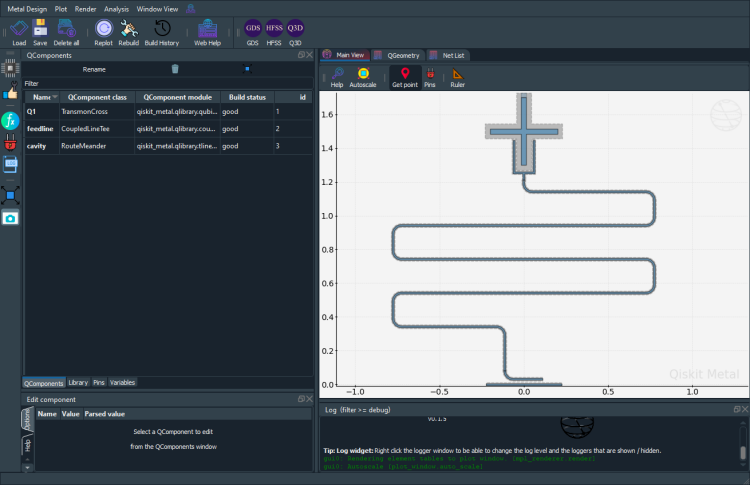

In [7]:
design = QubitCavity(design, options=best_options)


gui.rebuild()
gui.autoscale()
gui.screenshot()

In [10]:
list(design.components['Q1'].pin_names)[0]

'readout'

In [9]:
design.options

{'pos_x': 0,
 'pos_y': '0.0um',
 'orientation': 0,
 'chip': 'main',
 'layer': 1,
 'qubit_options': {'pos_x': 0,
  'pos_y': '1500um',
  'orientation': 180,
  'chip': 'main',
  'layer': 1,
  'connection_pads': {'readout': {'connector_type': 0,
    'claw_length': '185um',
    'ground_spacing': '4um',
    'claw_width': '10um',
    'claw_gap': '6um',
    'claw_cpw_length': '40um',
    'claw_cpw_width': '10um',
    'connector_location': 90}},
  'cross_width': '30um',
  ' cross_length': '185um',
  'cross_gap': '29um',
  'hfss_inductance': '10nH',
  'hfss_capacitance': 0,
  'hfss_resistance': 0,
  'hfss_mesh_kw_jj': 7e-06,
  'q3d_inductance': '10nH',
  'q3d_capacitance': 0,
  'q3d_resistance': 0,
  'q3d_mesh_kw_jj': 7e-06,
  'gds_cell_name': 'my_other_junction',
  'aedt_q3d_inductance': 1e-08,
  'aedt_q3d_capacitance': 0,
  'aedt_hfss_inductance': 1.2e-08,
  'aedt_hfss_capacitance': 0},
 'cavity_options': {'coupling_type': 'capacitive',
  'coupler_options': {'orientation': 180,
   'pos_x': 0,


In [10]:
design.misc

AttributeError: 'QubitCavity' object has no attribute 'misc'

In [20]:
import csv
import pandas as pd

class QubitCavityCSVGenerator:
    """A class to generate a QubitCavity.csv file from qiskit metal design options, Hamiltonian parameters, and simulation info."""
    
    def __init__(self, design, H_params, sim_info):
        """
        Initializes the QubitCavityCSVGenerator class.

        Parameters:
        design (dict): The design options from the qiskit metal design.
        H_params (dict): The Hamiltonian parameters for the system.
        sim_info (str): Miscellaneous simulation information.
        """
        self.design = design
        self.H_params = H_params
        self.sim_info = sim_info

    def flatten_dict(self, d, parent_key='', sep='.'):
        """
        Flattens a nested dictionary structure.

        Parameters:
        d (dict): Dictionary to flatten.
        parent_key (str): The parent key for nested dictionary items.
        sep (str): The separator used in the flattened keys.

        Returns:
        dict: The flattened dictionary.
        """
        items = {}
        for k, v in d.items():
            new_key = f"{parent_key}{sep}{k}" if parent_key else k
            if isinstance(v, dict):
                items.update(self.flatten_dict(v, new_key, sep=sep))
            else:
                items[new_key] = v
        return items

    def generate_csv(self, name="QubitCavity.csv"):
        """
        Generates the QubitCavity.csv file.
        """
        flat_design = self.flatten_dict(self.design)
    
        # Create a DataFrame from the flattened design dictionary
        df_design = pd.DataFrame([flat_design])
    
        # Create a DataFrame from the Hamiltonian parameters
        df_H_params = pd.DataFrame([self.H_params])
    
        # Create a DataFrame for the miscellaneous simulation info
        df_sim_info = pd.DataFrame({'misc': [self.sim_info]})
    
        # Concatenate the DataFrames horizontally and insert the "__SPLITTER__" column
        df_final = pd.concat([df_design, pd.DataFrame({'__SPLITTER__': ['split']}), df_H_params, df_sim_info], axis=1)
    
        # Fill NaN for empty cells
        df_final.fillna(value=np.nan, inplace=True)
    
        # Explicitly set data type for float columns if required
        for col in df_final.columns:
            if df_final[col].dtype == 'object':
                try:
                    df_final[col] = df_final[col].astype(float)
                except ValueError:
                    pass  # if conversion fails, keep as object
    
        # Write to CSV
        df_final.to_csv(name, index=False)



In [17]:
H_params = {
    "Qubit_Frequency_GHz": 4.368966835,
    "Qubit_Anharmonicity_MHz": 208.7318843,
    "Cavity_Frequency_GHz": 7,
    "Coupling_Strength_MHz": 200,
    "Cavity_Wavelength": "half",
    "Coupling_Type": "capacitive"
}

sim_info = "test"


In [19]:
# Create an instance of the QubitCavityCSVGenerator class
qubit_cavity_csv_gen = QubitCavityCSVGenerator(design.options, H_params, sim_info)

# Generate the QubitCavity.csv file
qubit_cavity_csv_gen.generate_csv("test.csv")

  df_final.fillna(value=pd.np.nan, inplace=True)

